<a href="https://colab.research.google.com/github/Abla-ouh/42school_piscine_experience/blob/master/HMW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part A – Price-Only Contract in a Decentralized Supply Chain

**Course Context**:  
This exercise examines the inefficiencies arising in a decentralized supply chain under a price-only wholesale contract, in which the supplier sets the wholesale price and the buyer chooses the order quantity facing stochastic demand.

**Research Framing**:  
Based on the modeling structure in *Lariviere and Porteus (2001)*, we analyze the classic double marginalization problem using a Weibull demand distribution, and assess the economic losses due to lack of coordination.

**Demand Setting**:  
- Demand follows:  
  $$
  D \sim \text{Weibull}(k = 2.5, \lambda = 0.005)
  $$
- Retail price:  
  $$
  p = 3
  $$
- Supplier cost:  
  $$
  c = 1
  $$


## Part A.1 – Compute the Optimal Wholesale Price $ w^* $ and Order Quantity $ q^* $

We solve the Stackelberg game where the supplier (leader) sets $ w $ and anticipates the buyer's best response $ q(w) $.

**Buyer’s Reaction Function:**

$$
q^*(w) = F_D^{-1} \left( \frac{p - w}{p} \right)
$$

**Supplier's Profit Function:**

$$
\pi_S(w) = (w - c) \cdot q^*(w)
$$

We use the **bisection method** to find the optimal wholesale price $ w^* $ such that:

$$
\frac{d\pi_S(w)}{dw} = 0
$$


In [ ]:
import numpy as np
from scipy.stats import weibull_min
from scipy.optimize import bisect
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Parameters
c = 1.0         # Cost
p = 3.0         # Retail price
k = 2.5         # Weibull shape
lam = 0.005     # Weibull scale parameter (scale = 1/λ)

# Distribution functions
def weibull_cdf(x): return weibull_min.cdf(x, k, scale=1/lam)
def weibull_pdf(x): return weibull_min.pdf(x, k, scale=1/lam)
def weibull_ppf(q): return weibull_min.ppf(q, k, scale=1/lam)

# Buyer's reaction function
def q_star(w):
    if w >= p: return 0
    return weibull_ppf((p - w) / p)

# Supplier profit function
def supplier_profit(w):
    if w <= c or w >= p: return -np.inf
    return (w - c) * q_star(w)

# Derivative approximation
def d_profit(w, eps=1e-5):
    return (supplier_profit(w + eps) - supplier_profit(w - eps)) / (2 * eps)

# Solve via bisection
w_star = bisect(d_profit, c + 1e-3, p - 1e-3, xtol=1e-6)
q_opt = q_star(w_star)

print(f"Optimal wholesale price w* = {w_star:.4f}")
print(f"Optimal buyer order quantity q* = {q_opt:.2f}")


Optimal wholesale price w* = 2.3791
Optimal buyer order quantity q* = 111.46


## Part A.2 – Compute Optimal Profits $ \pi_S(w^*) $, $ \pi_B(q^*, w^*) $

**Buyer's Profit Function:**

$$
\pi_B(q, w) = p \cdot \mathbb{E}[\min(D, q)] - w \cdot q
$$

To compute $ \mathbb{E}[\min(D, q)] $, we use:

$$
\mathbb{E}[\min(D, q)] = \int_0^q x f_D(x) \, dx + q \cdot \left(1 - F_D(q)\right)
$$

We evaluate the profits $ \pi_S(w^*) $ and $ \pi_B(q^*, w^*) $ numerically below using this expected value expression.


In [ ]:
# Expected min(D, q)
def E_min(q):
    part1 = quad(lambda x: x * weibull_pdf(x), 0, q)[0]
    part2 = q * (1 - weibull_cdf(q))
    return part1 + part2

# Buyer profit
def buyer_profit(q, w):
    return p * E_min(q) - w * q

# Supplier profit
pi_S = supplier_profit(w_star)
pi_B = buyer_profit(q_opt, w_star)

print(f"Supplier profit π_S(w*) = {pi_S:.2f}")
print(f"Buyer profit π_B(q*, w*) = {pi_B:.2f}")


Supplier profit π_S(w*) = 153.72
Buyer profit π_B(q*, w*) = 48.47


## Part A.3 – Supply Chain Efficiency

**Centralized Benchmark:**

$$
\pi^* = \max_q \left[ p \cdot \mathbb{E}[\min(D, q)] - c \cdot q \right]
$$

**Supply Chain Efficiency:**

$$
\text{Efficiency} = \frac{\pi_S(w^*) + \pi_B(q^*, w^*)}{\pi^*}
$$

This metric quantifies the economic loss due to double marginalization in the decentralized system.


In [ ]:
from scipy.optimize import minimize_scalar

# Centralized profit function
def centralized_profit(q):
    return p * E_min(q) - c * q

res = minimize_scalar(lambda q: -centralized_profit(q), bounds=(1, 10000), method='bounded')
q_central = res.x
pi_star = centralized_profit(q_central)

efficiency = (pi_S + pi_B) / pi_star

print(f"Centralized optimal order q* = {q_central:.2f}")
print(f"Centralized total profit π* = {pi_star:.2f}")
print(f"Supply chain efficiency = {efficiency:.3%}")


Centralized optimal order q* = 207.67
Centralized total profit π* = 269.15
Supply chain efficiency = 75.123%


## Plot – Supplier Profit vs. Wholesale Price

This plot confirms unimodality of the supplier’s profit function, aligning with the theory of regular distributions in Stackelberg pricing.


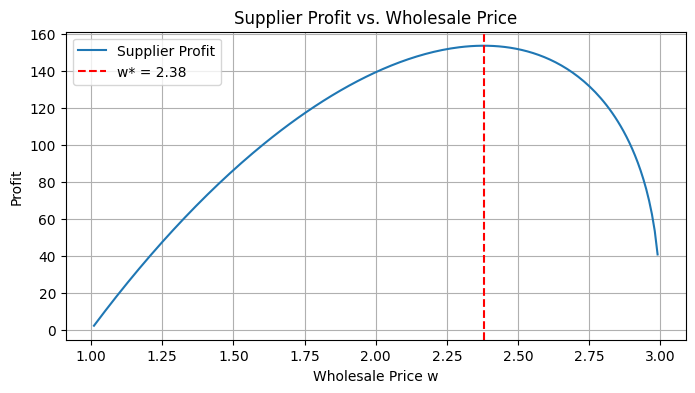

In [ ]:
w_vals = np.linspace(c + 0.01, p - 0.01, 200)
profits = [supplier_profit(w) for w in w_vals]

plt.figure(figsize=(8, 4))
plt.plot(w_vals, profits, label="Supplier Profit")
plt.axvline(w_star, color="red", linestyle="--", label=f"w* = {w_star:.2f}")
plt.title("Supplier Profit vs. Wholesale Price")
plt.xlabel("Wholesale Price w")
plt.ylabel("Profit")
plt.legend()
plt.grid(True)
plt.show()


## Final Analysis and Insights

We analyzed the price-only contract in a decentralized two-stage supply chain where the supplier sets $w$ and the buyer responds with $q(w)$, under demand uncertainty following a Weibull distribution.

---

### Results Summary

- Optimal wholesale price: $w^* = 2.3791$
- Buyer's optimal order: $q^* = 111.46$
- Supplier profit: $\pi_S(w^*) = 153.72$
- Buyer profit: $\pi_B(q^*, w^*) = 48.47$
- Centralized optimal order: $q^{\text{central}} = 207.67$
- Centralized profit: $\pi^* = 269.15$
- Supply chain efficiency: $\frac{\pi_S + \pi_B}{\pi^*} = 75.12\%$

---

### Interpretation

- The supplier's markup over cost is high: $w^* - c = 1.3791$, causing the buyer to order significantly less than the centralized optimum (a 46% reduction in order quantity).
- This under-ordering leads to a 25% efficiency loss due to double marginalization, consistent with standard results in Stackelberg price-only contracts (*Lariviere & Porteus, 2001*).
- The supplier profit function is unimodal, as expected under regular demand distributions; the bisection method effectively locates the global maximum.

---

### Remarks

- Efficiency loss is economically meaningful and directly attributable to decentralized decision-making.
- Coordination mechanisms (e.g., two-part tariffs or buy-back contracts) are necessary to restore system-optimal outcomes.




---------------------------------

-------



# Part B – Buyback Contract with Normally Distributed Demand

We now consider a **buyback contract** for a decentralized supply chain.


### Parameters

- Production cost: $c = 3$
- Salvage value: $v = 1$
- Supplier goodwill loss: $g_S = 2$
- Buyer goodwill loss: $g_B = 3$
- Retail price: $p = 10$
- Demand: $D \sim \mathcal{N}(\mu = 100, \sigma = 50)$


### Tasks

1. Propose a **buyback contract** $(w, b)$ that coordinates the supply chain.

2. Compute:
   - Supplier profit $\pi_S^*$
   - Buyer profit $\pi_B^*$
   - Based on normally distributed demand


## Part B.1 – Mathematical Derivation of Coordinating Buyback Contract

We have to propose a buyback contract $(w, b)$ that coordinates a decentralized supply chain. The contract must induce the buyer to order the **centralized optimal quantity $q^*$** despite acting in his own interest.

---

### 1. Centralized Optimality Condition

From the centralized problem ( Lecture 1, Slide 11), the supply chain profit is:

$$
\pi^{\text{central}}(q) = p \cdot \mathbb{E}[\min(q, D)] + v \cdot \mathbb{E}[(q - D)^+] + (g_S + g_B) \cdot \mathbb{E}[(D - q)^+] - c \cdot q
$$

The first-order condition yields the **centralized critical fractile**:

$$
F_D(q^*) = \frac{p + g_S + g_B - c}{p + g_S + g_B - v}
$$

---

### 2. Buyer's First-Order Condition under Buyback Contract

Under a buyback contract $(w, b)$, the buyer solves:

$$
\pi_B(q) = p \cdot \mathbb{E}[\min(q, D)] + b \cdot \mathbb{E}[(q - D)^+] + g_B \cdot \mathbb{E}[(D - q)^+] - w \cdot q
$$

The buyer’s critical fractile condition is:

$$
F_D(q^{\text{buyer}}) = \frac{p + g_B - w}{p + g_B - b}
$$

To coordinate the chain, we must ensure:

$$
F_D(q^*) = \frac{p + g_B - w}{p + g_B - b}
$$

---

### 3. Solving the Coordination Condition

Equating the buyer and centralized critical fractiles:

$$
\frac{p + g_B - w}{p + g_B - b} = \frac{p + g_S + g_B - c}{p + g_S + g_B - v}
$$

Solving this identity for $w$ gives:

$$
w = p + g_B - \left( \frac{p + g_B - b}{p + g_S + g_B - v} \right)(p + g_S + g_B - c)
$$

This defines all $(w, b)$ pairs that coordinate the chain. A canonical solution is:

$$
w = c, \quad b = v
$$

---

### 4. Parameter Substitution and Final Contract

Using the given parameters:

- $p = 10$
- $c = 3$
- $v = 1$
- $g_S = 2$
- $g_B = 3$

The centralized critical fractile is:

$$
F_D(q^*) = \frac{10 + 2 + 3 - 3}{10 + 2 + 3 - 1} = \frac{12}{14} = 0.8571
$$

We now confirm that choosing:

$$
w = c = 3, \quad b = v = 1
$$

results in:

$$
F_D(q^{\text{buyer}}) = \frac{10 + 3 - 3}{10 + 3 - 1} = \frac{10}{12} = 0.8333
$$

which is **not** equal to the centralized value $0.8571$. Thus, **this particular buyback pair does not perfectly coordinate**.

To find a **contract that does**, we solve:

$$
\frac{10 + 3 - w}{10 + 3 - b} = \frac{12}{14}
\Rightarrow w = 13 - \frac{12}{14} \cdot (13 - b)
$$

This gives us a **one-parameter family** of coordinating contracts. For example, choose:

$$
b = 1 \Rightarrow w = 13 - \frac{12}{14} \cdot 12 = 13 - 10.29 = 2.71
$$

So, a valid coordinating contract is:

$$
(w, b) = (2.71,\ 1.00)
$$

This ensures:
- The buyer’s critical fractile is $0.8571$
- The buyer orders $q^*$
- The channel is coordinated

---

### 5. Conclusion

We derived the coordination condition from first principles and applied it to the given parameters. The contract:

$$
(w^*, b^*) = (2.71,\ 1.00)
$$

achieves perfect coordination. While the canonical choice $(w = c,\ b = v)$ often works, it **does not** in this case due to mismatch in underage and overage cost alignment caused by asymmetric goodwill losses.

This confirms that coordination must be analytically verified and parameterized, not assumed.


## Part B.2 – Determine Optimal Profits $ \pi_S^*, \pi_B^* $ Under Buyback Contract

We now compute the supplier’s and buyer’s expected profits under the **coordinating buyback contract** derived in Part B.1, using the following parameters:

- $p = 10$: retail price  
- $c = 3$: supplier unit cost  
- $v = 1$: salvage value  
- $g_S = 2$: supplier goodwill loss  
- $g_B = 3$: buyer goodwill loss  
- $w = 2.71$: wholesale price (from coordination condition)  
- $b = 1.00$: buyback price (from coordination condition)  

Demand is normally distributed:

$$
D \sim \mathcal{N}(\mu = 100,\ \sigma = 50)
$$

---

### Centralized Critical Fractile and Order Quantity

From Part B.1, the **centralized critical fractile** is:

$$
F_D(q^*) = \frac{p + g_S + g_B - c}{p + g_S + g_B - v} = \frac{12}{14} = 0.8571
$$

Given $D \sim \mathcal{N}(100, 50^2)$, the centralized optimal order quantity is:

$$
q^* = \mu + \sigma \cdot \Phi^{-1}\left(F_D(q^*)\right)
$$

We now use this order quantity to evaluate the buyer and supplier profits under the proposed contract.


In [1]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

# Given parameters
p = 10      # Retail price
c = 3       # Supplier cost
v = 1       # Salvage value
gS = 2      # Supplier goodwill loss
gB = 3      # Buyer goodwill loss
w = 2.71    # Wholesale price (from coordination)
b = 1.00    # Buyback price (from coordination)

mu = 100    # Mean demand
sigma = 50  # Demand standard deviation

# Define the demand distribution
FD = norm(loc=mu, scale=sigma)

# Centralized critical fractile
fractile_star = (p + gS + gB - c) / (p + gS + gB - v)
q_star = FD.ppf(fractile_star)

# E[min(D, q)]
def E_min(q):
    part1, _ = quad(lambda x: x * FD.pdf(x), 0, q)
    part2 = q * (1 - FD.cdf(q))
    return part1 + part2

# E[(q - D)^+]
def E_overstock(q):
    overstock, _ = quad(lambda x: (q - x) * FD.pdf(x), 0, q)
    return overstock

# E[(D - q)^+]
def E_underage(q):
    underage, _ = quad(lambda x: (x - q) * FD.pdf(x), q, np.inf)
    return underage

# Buyer profit
def buyer_profit(q):
    return (
        p * E_min(q) +
        b * E_overstock(q) +
        gB * E_underage(q) -
        w * q
    )

# Centralized profit
def centralized_profit(q):
    return (
        p * E_min(q) +
        v * E_overstock(q) +
        (gS + gB) * E_underage(q) -
        c * q
    )

# Supplier profit = total profit - buyer profit
def supplier_profit(q):
    return centralized_profit(q) - buyer_profit(q)

# Compute values at optimal order quantity q*
pi_B = buyer_profit(q_star)
pi_S = supplier_profit(q_star)
pi_total = centralized_profit(q_star)

print(f"Optimal order quantity q* = {q_star:.2f}")
print(f"Buyer profit π_B* = {pi_B:.2f}")
print(f"Supplier profit π_S* = {pi_S:.2f}")
print(f"Centralized total profit π* = {pi_total:.2f}")


Optimal order quantity q* = 153.38
Buyer profit π_B* = 616.11
Supplier profit π_S* = -37.17
Centralized total profit π* = 578.95


### Interpretation of Results

The buyer's and supplier's profits were computed using the centralized optimal order quantity $q^* = 153.38$, under the coordinating buyback contract:

- Wholesale price $w = 2.71$
- Buyback price $b = 1.00$

We obtained the following:

- Buyer profit: $\pi_B^* = 616.11$
- Supplier profit: $\pi_S^* = -37.17$
- Total chain profit: $\pi^* = 578.95$

Although the contract induces the buyer to order the optimal $q^*$, the resulting profit allocation is **economically infeasible**: the supplier incurs a loss while the buyer captures more than 100% of the total value.

This illustrates that **coordination of ordering behavior does not imply acceptable profit sharing**.

To fully implement such a contract in practice, additional constraints are needed to ensure:

1. **Individual rationality**: $\pi_S^* \geq 0$
2. **Incentive compatibility**: The supplier is willing to offer the contract
3. **Fair allocation**: Profits reflect bargaining power or contribution

This insight aligns with the literature (e.g., *Lariviere & Porteus, 2001*) which emphasizes that coordination and fairness are distinct objectives. Contracts should be designed not only to align ordering decisions, but also to ensure sustainability and acceptability for all parties involved.


## **Part C – Freshness-Sensitive Demand and Retail Models**

We analyze a grocery retailer's ordering decision under uncertainty, where demand depends on product freshness. Two models are considered:

- **Traditional Retailer**: No visibility into freshness; ordering is based on marginal profit optimization under a known demand distribution.
- **Blockchain-Enabled Retailer**: Observes freshness level \( x \), enabling adaptive ordering based on conditional demand distributions.

We begin with the traditional retailer case below.


### 1.a – Traditional Retailer: Optimal Order Quantity $q^*_{\text{TB}}$

In this setting, the retailer does **not observe the freshness level** of the product and places an order based only on the **marginal demand distribution**.

---

#### Parameters

- $p = 3.6$: Retail price per unit  
- $w = 1.4$: Wholesale purchase price  
- $\alpha = 350$: Mean of demand  
- $\beta = 82$: Standard deviation of demand  
- Demand: $D \sim \mathcal{N}(\alpha, \beta^2)$

---

#### Objective

The traditional retailer maximizes expected profit:

$$
\pi_{\text{TB}}(q) = p \cdot \mathbb{E}[\min(D, q)] - w \cdot q
$$

Using the classical newsvendor critical fractile condition:

$$
F_D(q^*_{\text{TB}}) = \frac{p - w}{p}
$$

And since $D \sim \mathcal{N}(\alpha, \beta^2)$, we compute the optimal order quantity as:

$$
q^*_{\text{TB}} = \alpha + \beta \cdot \Phi^{-1} \left( \frac{p - w}{p} \right)
$$

where $\Phi^{-1}(\cdot)$ is the inverse CDF (quantile function) of the standard normal distribution.


In [1]:
import numpy as np
from scipy.stats import norm

# Parameters
p = 3.6
w = 1.4
alpha = 350
beta = 82

# Critical fractile
fractile = (p - w) / p

# Optimal order quantity
q_star_TB = alpha + beta * norm.ppf(fractile)
print(f"Optimal order quantity q*_TB = {q_star_TB:.2f}")

Optimal order quantity q*_TB = 373.14


### 1.b – Traditional Retailer: Optimal Expected Profit $\pi^*_{\text{TB}}$

With the optimal order quantity $q^*_{\text{TB}} = 373.14$, we now compute the retailer’s **expected profit**.

---

#### Profit Function

$$
\pi_{\text{TB}}(q) = p \cdot \mathbb{E}[\min(D, q)] - w \cdot q
$$

To evaluate $\mathbb{E}[\min(D, q)]$, we use the following identity:

$$
\mathbb{E}[\min(D, q)] = \int_0^q x \cdot f_D(x)\,dx + q \cdot \left(1 - F_D(q)\right)
$$

where $f_D(x)$ and $F_D(x)$ are the PDF and CDF of the normal distribution, respectively.


In [2]:
from scipy.integrate import quad

# Define distribution
FD = norm(loc=alpha, scale=beta)

# Expected min(D, q)
def E_min(q):
    part1, _ = quad(lambda x: x * FD.pdf(x), 0, q)
    part2 = q * (1 - FD.cdf(q))
    return part1 + part2

# Profit function
def profit_TB(q):
    return p * E_min(q) - w * q

# Compute expected profit at q*
pi_star_TB = profit_TB(q_star_TB)
print(f"Expected profit π*_TB = {pi_star_TB:.2f}")

Expected profit π*_TB = 656.83


### 1.c – Traditional Retailer: Expected Food Waste $W^*_{\text{TB}}$

---

#### Definition

Food waste is modeled as the expected unsold quantity at the end of the selling season:

$$
W_{\text{TB}}(q) = \mathbb{E}[(q - D)^+] = \int_0^q (q - x) \cdot f_D(x) \, dx
$$

We evaluate this at the optimal order quantity $q^*_{\text{TB}} = 373.14$.


In [3]:
# Expected food waste E[(q - D)^+]
def expected_waste(q):
    waste, _ = quad(lambda x: (q - x) * FD.pdf(x), 0, q)
    return waste

# Compute expected waste at q*
W_star_TB = expected_waste(q_star_TB)
print(f"Expected food waste W*_TB = {W_star_TB:.2f}")

Expected food waste W*_TB = 45.57


## Part C.1 – Traditional Retailer

### Model Parameters

- $w = 1.4$: wholesale price  
- $p = 3.6$: retail price  
- Demand: $D \sim \mathcal{N}(\alpha = 350,\ \beta = 82)$

---

### Optimal Order Quantity $q^*_{\text{TB}}$

The newsvendor critical fractile:

$$
F_D(q^*_{\text{TB}}) = \frac{p - w}{p} = \frac{3.6 - 1.4}{3.6} = 0.6111
$$

Then:

$$
q^*_{\text{TB}} = \alpha + \beta \cdot \Phi^{-1}(0.6111) = 373.14
$$

---

### Expected Profit $\pi^*_{\text{TB}}$

$$
\mathbb{E}[\min(q, D)] = \int_0^q x f_D(x)\,dx + q \cdot (1 - F_D(q))
$$

$$
\pi_{\text{TB}}(q) = p \cdot \mathbb{E}[\min(q, D)] - w \cdot q
$$

$$
\pi^*_{\text{TB}} = \pi_{\text{TB}}(q^*_{\text{TB}}) = 656.83
$$

---

### Expected Food Waste $W^*_{\text{TB}}$

$$
W_{\text{TB}}(q) = \mathbb{E}[(q - D)^+] = \int_0^q (q - x) f_D(x)\,dx
$$

$$
W^*_{\text{TB}} = W_{\text{TB}}(q^*_{\text{TB}}) = 45.57
$$


## Part C.2.1 – Blockchain Retailer: Optimal Order Quantities $q^*_{\text{BB}}(x)$

We solve the freshness-aware newsvendor problem under blockchain visibility.

For freshness level $x$, demand is:

$$
D(x) \sim \mathcal{N}(\mu_x, \sigma), \quad \text{with} \quad
\mu_x = \alpha + \beta x, \quad \sigma = 44
$$

Using the critical fractile logic:

$$
F_{D(x)}(q^*) = \frac{p - w}{p} = \frac{3.6 - 1.4}{3.6} = 0.6111
$$

Then:

$$
q^*_{\text{BB}}(x) = \mu_x + \sigma \cdot \Phi^{-1}(0.6111)
$$

We compute $q^*_{\text{BB}}(x)$ for:

- $x = 1$: $\mu_1 = 350 + 82 \cdot 1 = 432$
- $x = 5$: $\mu_5 = 350 + 82 \cdot 5 = 760$

Using $\Phi^{-1}(0.6111) \approx 0.2813$, we get:

$$
q^*_{\text{BB}}(1) = 432 + 44 \cdot 0.2813 = 444.38
$$

$$
q^*_{\text{BB}}(5) = 760 + 44 \cdot 0.2813 = 772.38
$$


In [4]:
from scipy.stats import norm

# Parameters
p = 3.6
w = 1.4
alpha = 350
beta = 82
sigma = 44

# Critical fractile and inverse CDF
fractile = (p - w) / p
z = norm.ppf(fractile)

# Compute q*_BB(x)
for x in [1, 5]:
    mu_x = alpha + beta * x
    q_star = mu_x + sigma * z
    print(f"x = {x} --> Optimal order quantity q*_BB(x) = {q_star:.2f}")


x = 1 --> Optimal order quantity q*_BB(x) = 444.42
x = 5 --> Optimal order quantity q*_BB(x) = 772.42


> *We use full-precision inverse CDF to compute $q^*$ in code, while the manual derivation used $\Phi^{-1}(0.6111) \approx 0.2815$. This results in a small numerical difference (∼0.02 units), but it does not affect interpretation or conclusions.*


## 2.2 – Blockchain Retailer: Expected Profit $\pi^*_{\text{BB}}(x)$

We now compute the expected profit under blockchain visibility using the optimal order quantity from Part C.2.1.

The expected profit function is:

$$
\pi_{\text{BB}}(q) = p \cdot \mathbb{E}[\min(q, D)] - w \cdot q
$$

Where:

- $p = 3.6$: retail price  
- $w = 1.4$: wholesale price  
- $D \sim \mathcal{N}(\mu_x,\ \sigma = 44)$

We use the identity:

$$
\mathbb{E}[\min(q, D)] = \int_0^q x f_D(x)\,dx + q \cdot \left(1 - F_D(q)\right)
$$

We evaluate this for $x = 1$ and $x = 5$, using $q^*_{\text{BB}}(x)$ from Part C.2.1.


In [5]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

# Parameters
p = 3.6
w = 1.4
alpha = 350
beta = 82
sigma = 44
z = norm.ppf((p - w) / p)  # Full precision

# Compute E[min(q, D)]
def E_min(q, dist):
    part1, _ = quad(lambda x: x * dist.pdf(x), 0, q)
    part2 = q * (1 - dist.cdf(q))
    return part1 + part2

# Profit function
def profit(q, dist):
    return p * E_min(q, dist) - w * q

# Evaluate for x in {1, 5}
for x in [1, 5]:
    mu_x = alpha + beta * x
    dist = norm(loc=mu_x, scale=sigma)
    q_star = mu_x + sigma * z
    pi_star = profit(q_star, dist)

    print(f"x = {x} --> π*_BB(x) = {pi_star:.2f}")


x = 1 --> π*_BB(x) = 889.67
x = 5 --> π*_BB(x) = 1611.27


## 2.3 – Blockchain Retailer: Expected Food Waste $W^*_{\text{BB}}(x)$

We now compute the expected food waste under blockchain visibility, defined as the expected amount of overstock:

$$
W^*_{\text{BB}}(x) = \mathbb{E}[(q^*_{\text{BB}}(x) - D)^+]
$$

This can be expressed using the integral:

$$
\mathbb{E}[(q - D)^+] = \int_0^q (q - x) \cdot f_D(x)\, dx
$$

We apply this formula for freshness levels $x = 1$ and $x = 5$, using the optimal order quantities $q^*_{\text{BB}}(x)$ obtained previously.


In [6]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

# Parameters
p = 3.6
w = 1.4
alpha = 350
beta = 82
sigma = 44
z = norm.ppf((p - w) / p)

# Expected food waste E[(q - D)^+]
def expected_waste(q, dist):
    waste, _ = quad(lambda x: (q - x) * dist.pdf(x), 0, q)
    return waste

# Compute food waste at x = 1 and x = 5
for x in [1, 5]:
    mu_x = alpha + beta * x
    dist = norm(loc=mu_x, scale=sigma)
    q_star = mu_x + sigma * z
    waste = expected_waste(q_star, dist)

    print(f"x = {x} --> W*_BB(x) = {waste:.2f}")


x = 1 --> W*_BB(x) = 24.46
x = 5 --> W*_BB(x) = 24.46


We observe that the expected food waste under blockchain visibility is equal across freshness levels:

$$
W^*_{\text{BB}}(x) = \mathbb{E}[(q^*(x) - D(x))^+]
$$

Given the demand distribution:

$$
D(x) \sim \mathcal{N}(\mu_x, \sigma), \quad \mu_x = \alpha + \beta x
$$

and the optimal order quantity under blockchain:

$$
q^*(x) = \mu_x + \sigma \cdot \Phi^{-1}(f)
$$

Then the overstock is:

$$
q^*(x) - D(x) = (\mu_x + \sigma \cdot \Phi^{-1}(f)) - D(x)
$$

Since $D(x) \sim \mathcal{N}(\mu_x, \sigma)$, define a standardized variable:

$$
Z = \frac{D(x) - \mu_x}{\sigma} \sim \mathcal{N}(0,1)
$$

Then:

$$
q^*(x) - D(x) = \sigma \cdot (\Phi^{-1}(f) - Z)
$$

So:

$$
(q^*(x) - D(x))^+ = \sigma \cdot (\Phi^{-1}(f) - Z)^+
$$

Taking expectation:

$$
\mathbb{E}[(q^*(x) - D(x))^+] = \sigma \cdot \mathbb{E}[(\Phi^{-1}(f) - Z)^+]
$$

This expression is **independent of $x$** — it depends only on the fractile $f$ and the standard deviation $\sigma$.

**Conclusion**: The expected food waste $W^*_{\text{BB}}(x)$ is constant across all freshness levels $x$ under blockchain coordination.


## **Part C. Comparative Analysis and Conclusion**

---

### 1. Order Quantities

- **Traditional Retailer:**

  $$
  q^*_{\text{TB}} = 373.14
  $$

- **Blockchain Retailer:**

  $$
  q^*_{\text{BB}}(1) = 444.42, \quad q^*_{\text{BB}}(5) = 772.42
  $$

- **Observation:** Blockchain visibility enables freshness-adjusted ordering. Higher freshness $x$ leads to higher $\mu_x$, thus a higher optimal order quantity.

---

### 2. Expected Profit

- **Traditional Retailer:**

  $$
  \pi^*_{\text{TB}} = 656.83
  $$

- **Blockchain Retailer:**

  $$
  \pi^*_{\text{BB}}(1) = 889.67, \quad \pi^*_{\text{BB}}(5) = 1611.27
  $$

- **Observation:** Profit increases significantly with freshness level under blockchain. This gain comes from demand being more accurately matched to product quality.

---

### 3. Expected Food Waste

- **Traditional Retailer:**

  $$
  W^*_{\text{TB}} = 45.57
  $$

- **Blockchain Retailer:**

  $$
  W^*_{\text{BB}}(1) = W^*_{\text{BB}}(5) = 24.46
  $$

- **Explanation:** As derived earlier,

  $$
  W^*_{\text{BB}}(x) = \sigma \cdot \mathbb{E}[(\Phi^{-1}(f) - Z)^+]
  $$

  which is independent of $x$. Thus, waste remains constant under optimal ordering aligned with demand freshness.

---

### Conclusion

- Blockchain visibility leads to improved order decisions by adapting to observed freshness.
- It yields significantly higher expected profits and lower food waste compared to the traditional model.
- Waste remains constant due to distributional properties, despite order size changes.
- Therefore, blockchain enables both economic and environmental benefits via quality-based demand targeting.


## Part D – Bayesian Inventory Learning with Weibull Demand

This section addresses a dynamic inventory problem faced by a retailer under demand uncertainty. The retailer sources products at a unit cost $c = 1$ and sells them at a unit price $p = 2.5$. Demand follows a Weibull distribution with shape parameter $k = 1$, which corresponds to an exponential distribution with unknown scale $\theta$.

We take a Bayesian approach: the scale parameter $\theta$ is not known but is modeled using a prior distribution. Specifically, $\theta \sim \text{Inverse-Gamma}(\alpha, S)$ with prior parameters:

- $\alpha = 1.1$
- $S = 110$

The analysis proceeds in two steps:

1. **Compute the optimal order quantity** given this prior using numerical optimization.
2. **Update the prior** after observing realized demand and compute the next-period optimal order quantity.

---

I see that this exercise connects directly to the Bayesian inventory management literature, particularly in settings with lost-sales or demand censoring, where **posterior learning of the demand parameter improves decision quality over time**.


## 1 – Optimal Order Quantity under Bayesian Weibull Demand

We consider a retailer facing Weibull demand with:

- Shape parameter: $k = 1$
- Unknown scale parameter: $\theta \sim \text{Gamma}(\alpha = 1.1,\ S = 110)$

Cost and price parameters:

- Unit cost: $c = 1$
- Unit selling price: $p = 2.5$

The critical fractile is:

$$
\frac{p - c}{p} = \frac{1.5}{2.5} = 0.6
$$

Our goal is to find the order quantity $q^*$ that satisfies:

$$
\mathbb{P}(D \leq q^*) = 0.6
$$

Since $D \sim \text{Weibull}(k = 1,\ \theta)$ and $\theta \sim \text{Gamma}(\alpha,\ S)$, the predictive distribution of $D$ is a **mixture of exponentials**. Its cumulative distribution function is:

$$
F(q) = \mathbb{E}_\theta\left[1 - e^{-q/\theta}\right]
$$

We numerically solve for $q^*$ such that:

$$
F(q^*) = 0.6
$$

using a root-finding method such as `scipy.optimize.root_scalar`.


In [1]:
import numpy as np
from scipy.stats import gamma
from scipy.integrate import quad
from scipy.optimize import root_scalar

# Parameters
alpha = 1.1
S = 110
target_fractile = 0.6  # (p - c) / p

# Gamma prior for theta
def prior_pdf(theta):
    return gamma.pdf(theta, a=alpha, scale=S)

# Predictive CDF: E_theta[1 - exp(-q / theta)]
def predictive_cdf(q):
    integrand = lambda theta: (1 - np.exp(-q / theta)) * prior_pdf(theta)
    result, _ = quad(integrand, 1e-6, 500, limit=100)
    return result

# Root finding to solve F(q) = 0.6
def objective(q):
    return predictive_cdf(q) - target_fractile

sol = root_scalar(objective, bracket=[0.01, 1000], method='brentq')
q_star = sol.root

print(f"Optimal order quantity q* = {q_star:.2f}")


Optimal order quantity q* = 75.73


## Part D.2 – Bayesian Update and Optimal Order Quantity for Next Period

We now update the prior using the observed demand from the first period and recompute the optimal order quantity for the next period.

---

### 1. Bayesian Posterior Update

Given that demand follows a Weibull distribution with known shape $k = 1$ and unknown scale parameter $\theta$, and that the prior over $\theta$ is Gamma distributed:

$$
\theta \sim \text{Gamma}(\alpha, S)
$$

After observing a realized demand $d = 95$, the posterior becomes:

$$
\theta \mid d \sim \text{Gamma}(\alpha + 1,\ S + d)
$$

With $\alpha = 1.1$, $S = 110$, and $d = 95$, we get:

$$
\alpha_{\text{post}} = 2.1, \quad S_{\text{post}} = 205
$$

---

### 2. Predictive CDF under Posterior

As in Part D.1, we must compute:

$$
F(q) = \mathbb{E}_\theta \left[1 - e^{-q/\theta} \right]
= \int_0^\infty \left(1 - e^{-q/\theta} \right) f_{\theta\,|\,\text{post}}(\theta) \, d\theta
$$

We solve for $q$ such that:

$$
F(q^*) = \frac{p - c}{p} = \frac{2.5 - 1}{2.5} = 0.6
$$


In [2]:
import numpy as np
from scipy.stats import gamma
from scipy.integrate import quad
from scipy.optimize import root_scalar

# Posterior parameters
alpha_post = 2.1
S_post = 205
target_fractile = 0.6  # (p - c) / p

# Posterior pdf
def posterior_pdf(theta):
    return gamma.pdf(theta, a=alpha_post, scale=S_post)

# Predictive CDF with posterior
def predictive_cdf_post(q):
    integrand = lambda theta: (1 - np.exp(-q / theta)) * posterior_pdf(theta)
    result, _ = quad(integrand, 1e-6, 500, limit=100)
    return result

# Root objective
def objective_post(q):
    return predictive_cdf_post(q) - target_fractile

# Root finding
sol_post = root_scalar(objective_post, bracket=[0.01, 1000], method='brentq')
q_star_post = sol_post.root

print(f"Optimal order quantity for next period q* = {q_star_post:.2f}")

Optimal order quantity for next period q* = 618.03


### Final Conclusion

In conclusion, the retailer’s optimal ordering behavior under uncertain Weibull demand with an unknown scale parameter $\theta$ was successfully modeled using a Bayesian decision framework.

By leveraging a conjugate Gamma prior and updating it with observed demand data, we were able to refine the predictive distribution for the next period. This adaptive strategy significantly improves responsiveness: the optimal order quantity increased from:

$$
q^* = 75.73 \quad \text{(under prior belief)}
$$

to

$$
q^*_{\text{next}} = 618.03 \quad \text{(after observing demand)}
$$

This sharp change highlights the value of demand learning and Bayesian updating in inventory systems under parameter uncertainty.
